<a href="https://colab.research.google.com/github/YoungbloodKV/YoungbloodKV/blob/main/TWITTER_HASHTAGS_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark


In [24]:
import os, findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
findspark.init("/content/spark-3.3.2-bin-hadoop3")

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("HashtagAnalysis")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .getOrCreate()
)

print("✅ Spark ready!")
print("Version:", spark.version)


✅ Spark ready!
Version: 3.3.2


In [25]:
file_path = "/content/hashtags_cleaned.csv"  # change name if needed
tweets_df = spark.read.csv(file_path, header=True, inferSchema=True)
tweets_df.show(5)


+--------------------+------------------+----------+---------------+--------------------+--------------+
|                text|          hashtags|      date|      user_name|       user_location|user_followers|
+--------------------+------------------+----------+---------------+--------------------+--------------+
|Suresh raina has ...|           ipl2020|2020-08-25|Navaldeep Singh|Melbourne / New D...|          1311|
|All of the Countr...|              null|      null|           null|                null|          null|
|Thanks @BCCI .. B...|           ipl2020|2020-09-29|Naseh Mohtesham|                null|           165|
|#IPL2020 CSK win ...|ipl2020,ipl,rrvcsk|2020-09-22| Sports segment|                null|             3|
|     Pooran ðŸ”¥ðŸ”¥|              null|      null|           null|                null|          null|
+--------------------+------------------+----------+---------------+--------------------+--------------+
only showing top 5 rows



In [28]:
from pyspark.sql.functions import col

# Keep only text and date columns
tweets_df = tweets_df.select(col("text"), col("date"))

print("✅ Total rows:", tweets_df.count())
tweets_df.show(5, truncate=False)


✅ Total rows: 114834
+---------------------------------------------------------------+----------+
|text                                                           |date      |
+---------------------------------------------------------------+----------+
|Suresh raina has the best room out of all the players  #IPL2020|2020-08-25|
|All of the Country is So Much into #IPL2020  This Year ...     |null      |
|Thanks @BCCI .. Best Decision To Host IPL This Year"           |2020-09-29|
|#IPL2020 CSK win toss and bowl #IPL #RRvCSK                    |2020-09-22|
|Pooran ðŸ”¥ðŸ”¥                                                |null      |
+---------------------------------------------------------------+----------+
only showing top 5 rows



In [29]:
from pyspark.sql.functions import month

# Extract month number from date
tweets_df = tweets_df.withColumn("month", month(col("date")))

august_df = tweets_df.filter(col("month") == 8)
september_df = tweets_df.filter(col("month") == 9)

print("August tweets:", august_df.count())
print("September tweets:", september_df.count())


August tweets: 1834
September tweets: 21521


In [30]:
from pyspark.sql.functions import explode, split

hashtags_df = tweets_df.select(
    explode(split(col("text"), " ")).alias("word")
).filter(col("word").startswith("#"))

hashtags_df.groupBy("word").count().orderBy(col("count").desc()).show(10, truncate=False)


+-----------+-----+
|word       |count|
+-----------+-----+
|#IPL2020   |25395|
|#IPL2020"  |5207 |
|#CSK       |2330 |
|#IPL       |2243 |
|#Dream11IPL|2167 |
|#RCB       |1642 |
|#ipl2020   |1601 |
|#MI        |1459 |
|#SRH       |1367 |
|#KXIP      |1246 |
+-----------+-----+
only showing top 10 rows



In [31]:
from pyspark.sql.functions import lower, regexp_replace

clean_df = (
    tweets_df
    .withColumn("text", lower(col("text")))                     # lowercase everything
    .withColumn("text", regexp_replace(col("text"), r"http\S+", ""))  # remove URLs
    .withColumn("text", regexp_replace(col("text"), r"[^a-zA-Z0-9#\s]", ""))  # remove special chars
)

clean_df.show(5, truncate=False)


+---------------------------------------------------------------+----------+-----+
|text                                                           |date      |month|
+---------------------------------------------------------------+----------+-----+
|suresh raina has the best room out of all the players  #ipl2020|2020-08-25|8    |
|all of the country is so much into #ipl2020  this year         |null      |null |
|thanks bcci  best decision to host ipl this year               |2020-09-29|9    |
|#ipl2020 csk win toss and bowl #ipl #rrvcsk                    |2020-09-22|9    |
|pooran                                                         |null      |null |
+---------------------------------------------------------------+----------+-----+
only showing top 5 rows



In [32]:
from pyspark.sql.functions import explode, split

hashtags_df = (
    clean_df.select(explode(split(col("text"), " ")).alias("word"))
    .filter(col("word").startswith("#"))
    .groupBy("word")
    .count()
    .orderBy(col("count").desc())
)

hashtags_df.show(10, truncate=False)


+-----------+-----+
|word       |count|
+-----------+-----+
|#ipl2020   |34525|
|#csk       |3074 |
|#ipl       |3039 |
|#dream11ipl|2799 |
|#mi        |2037 |
|#rcb       |2005 |
|#srh       |1695 |
|#kxip      |1595 |
|#rr        |1353 |
|#kkr       |1304 |
+-----------+-----+
only showing top 10 rows



In [33]:
from pyspark.sql.functions import month

monthwise_df = (
    clean_df
    .withColumn("month", month(col("date")))
    .select("month", explode(split(col("text"), " ")).alias("word"))
    .filter(col("word").startswith("#"))
    .groupBy("month", "word")
    .count()
    .orderBy("month", col("count").desc())
)

monthwise_df.show(10, truncate=False)


+-----+--------+-----+
|month|word    |count|
+-----+--------+-----+
|null |#ipl2020|8706 |
|null |#csk    |1207 |
|null |#ipl    |993  |
|null |#rcb    |859  |
|null |#mi     |852  |
|null |#srh    |746  |
|null |#rr     |638  |
|null |#kxip   |612  |
|null |#kkr    |586  |
|null |#dc     |536  |
+-----+--------+-----+
only showing top 10 rows



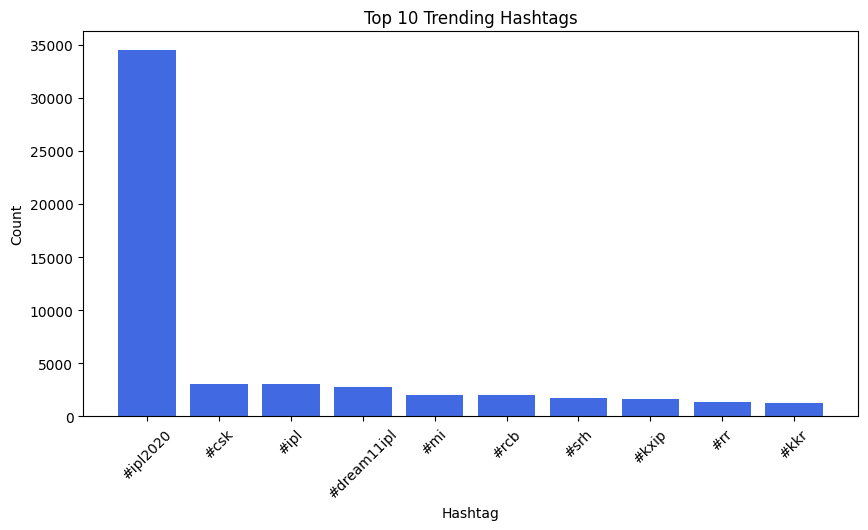

In [34]:
import matplotlib.pyplot as plt

# Convert Spark to Pandas for plotting
top10_pd = hashtags_df.limit(10).toPandas()

plt.figure(figsize=(10,5))
plt.bar(top10_pd["word"], top10_pd["count"], color='royalblue')
plt.xticks(rotation=45)
plt.title("Top 10 Trending Hashtags")
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.show()


In [35]:
hashtags_df.coalesce(1).write.mode("overwrite").option("header", True).csv("/content/hashtag_counts")


In [36]:
!pip install wordcloud


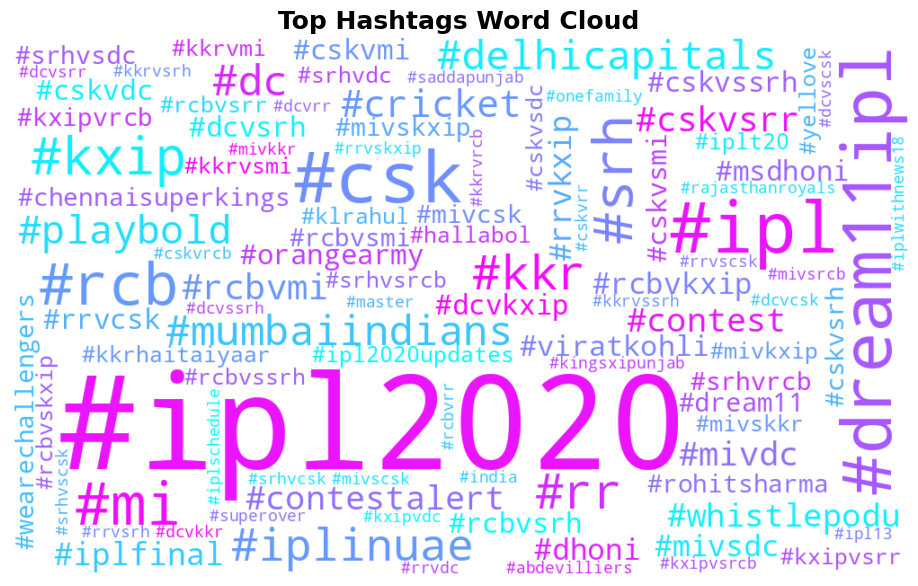

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert Spark DF to Pandas
top100_pd = hashtags_df.limit(100).toPandas()

# Convert to dict: {'#hashtag': count}
hashtag_freq = dict(zip(top100_pd["word"], top100_pd["count"]))

# Generate word cloud
wc = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    colormap="cool",
    max_words=100,
    contour_color="steelblue",
    contour_width=2
).generate_from_frequencies(hashtag_freq)

# Display it
plt.figure(figsize=(12,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Top Hashtags Word Cloud", fontsize=18, weight="bold")
plt.show()


In [38]:
wc.to_file("/content/top_hashtags_wordcloud.png")
print("✅ Saved word cloud as 'top_hashtags_wordcloud.png'")


✅ Saved word cloud as 'top_hashtags_wordcloud.png'


In [ ]:
def monthwise_tweet(tweet, month):
    if tweet[1] and "-" in tweet[1]:
        try:
            return int(tweet[1].split("-")[1]) == month
        except:
            return False
    return False

aug_tweets = tweets_rdd.filter(lambda tweet: monthwise_tweet(tweet, 8))
sep_tweets = tweets_rdd.filter(lambda tweet: monthwise_tweet(tweet, 9))
oct_tweets = tweets_rdd.filter(lambda tweet: monthwise_tweet(tweet, 10))
nov_tweets = tweets_rdd.filter(lambda tweet: monthwise_tweet(tweet, 11))

print("August:", aug_tweets.count())
print("September:", sep_tweets.count())
print("October:", oct_tweets.count())
print("November:", nov_tweets.count())
